In [1]:
import os
import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt

# SAUCIE,MAGIC,deepImpute,scScope,scVI,knn_smoothing
methods = ["SAUCIE", "MAGIC", "deepImpute", "scScope", "scVI", "knn_smoothing"]
# Load imputed matrix
dataset_id = "63ff2c52-cb63-44f0-bac3-d0b33373e312"
disease = "Crohn disease"
tissue = "lamina propria of mucosa of colon"

adata = anndata.read_h5ad(f"./datasets/{dataset_id}.h5ad")

print(adata.obs.columns)
mask = (adata.obs["disease"] == disease) & (adata.obs["tissue"] == tissue)
adata = adata[mask]

Index(['biosample_id', 'n_genes', 'n_counts', 'Type', 'donor_id', 'Layer',
       'Celltype', 'organism_ontology_term_id', 'assay_ontology_term_id',
       'disease_ontology_term_id', 'suspension_type', 'is_primary_data',
       'tissue_ontology_term_id', 'cell_type_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'age group',
       'sex_ontology_term_id', 'development_stage_ontology_term_id',
       'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex',
       'tissue', 'self_reported_ethnicity', 'development_stage',
       'observation_joinid'],
      dtype='object')


In [24]:
print(adata.obs)
print(adata.obs.organism.unique())
# total number of cells
print(adata.shape[0])


                           biosample_id  n_genes  n_counts  Type donor_id  \
cell_id                                                                     
N105446_L-ATTGTTCCAAACGTGG    N105446_L   2205.0   76317.0  NonI   105446   
N105446_L-TCGACGGGTGAGACCA    N105446_L   2088.0   67801.0  NonI   105446   
N105446_L-AGTAACCGTTAAGGGC    N105446_L   1862.0   58097.0  NonI   105446   
N105446_L-GCAGGCTTCGCTAAAC    N105446_L   5472.0   43418.0  NonI   105446   
N105446_L-ATCTTCATCTGAGAGG    N105446_L   5650.0   42871.0  NonI   105446   
...                                 ...      ...       ...   ...      ...   
N130084_L-GTGGTTACAGTTCCAA    N130084_L    305.0     488.0  NonI   130084   
N130084_L-TATCCTATCGTTCATT    N130084_L    294.0     490.0  NonI   130084   
N130084_L-TCATCCGGTATGATCC    N130084_L    268.0     453.0  NonI   130084   
N130084_L-GGTCACGGTTAGCGGA    N130084_L    289.0     442.0  NonI   130084   
N130084_L-TGGTGATAGTTGGAAT    N130084_L    224.0     344.0  NonI   130084   

In [29]:
import numpy as np
import json

# load marker genes
with open("./data/marker_genes.json", 'r') as f:
    marker_genes = json.load(f)

def expand_magic_matrix(original_matrix, imputed_matrix):
    """Expand MAGIC's imputed matrix to match original matrix dimensions."""
    expanded = np.zeros(original_matrix.shape)
    nonzero_counts = (original_matrix != 0).sum(axis=0)
    kept_genes = np.where(nonzero_counts >= 5)[0]
    for i, original_idx in enumerate(kept_genes):
        if i < imputed_matrix.shape[1]:
            expanded[:, original_idx] = imputed_matrix[:, i]
    return expanded

# Load imputed matrices for each method
imputed_matrices = []
valid_methods = []
for method in methods:
    # Try to load the imputed matrix
    try:
        # Construct the path (this would need to match your actual file structure)
        file_path = f"./output/{method}/{dataset_id}/{disease}/{tissue}.npy"
        imputed = np.load(file_path)
        if method == "MAGIC":
            # Expand MAGIC matrix to match original matrix dimensions
            imputed = expand_magic_matrix(adata.X, imputed)
        imputed_matrices.append(imputed)
        valid_methods.append(method)
        print(f"Loaded {method} matrix: {imputed.shape}")
    except:
        print(f"Failed to load {method}")

# Find the smallest number of genes across all matrices
min_genes = min([matrix.shape[1] for matrix in imputed_matrices])
print(f"Smallest number of genes across methods: {min_genes}")

# Filter all matrices to use only the first min_genes genes
filtered_matrices = []
for matrix in imputed_matrices:
    filtered_matrices.append(matrix[:, :min_genes])
    
# Also filter the original data
adata_filtered = adata[:, :min_genes].copy()

print(f"Filtered matrices to common dimensions: {adata_filtered.shape}")

# Define a function to calculate TH scores that handles sparse matrices properly
def calculate_th_scores(adata, imputed_matrices, methods):
    # Determine if sparse
    is_sparse = hasattr(adata.X, 'toarray')
    
    # Find zeros - for smaller matrices, we can just convert to dense
    if is_sparse:
        X_dense = adata.X.toarray()
        zero_mask = X_dense == 0
    else:
        zero_mask = adata.X == 0
        
    zero_indices = np.where(zero_mask)
    
    # Equal weights for all methods
    weights = {method: 1.0/len(methods) for method in methods}
    
    # Calculate scores
    n_zeros = len(zero_indices[0])
    scores = np.zeros(n_zeros)
    values = np.zeros(n_zeros)
    
    for i, method_name in enumerate(methods):
        imputed = imputed_matrices[i]
        weight = weights[method_name]
        
        # Extract values at zero positions
        imputed_values = np.zeros(n_zeros)
        for j, (r, c) in enumerate(zip(zero_indices[0], zero_indices[1])):
            imputed_values[j] = imputed[r, c]
        
        # Update scores (1 if imputed > 0, else 0)
        ZERO_TOLERANCE = 0
        scores += weight * (np.abs(imputed_values) >= ZERO_TOLERANCE).astype(float)
        
        # Update consensus values
        values += weight * imputed_values
    
    return {
        "zero_indices": zero_indices,
        "scores": scores,
        "values": values,
        "method_weights": weights,
        "valid_methods": methods,
    }

th_results = [calculate_th_scores(adata_filtered, filtered_matrices, valid_methods)]
print(f"Calculated TH scores for {len(th_results[0]['scores'])} zeros")


Loaded SAUCIE matrix: (8076, 27289)
Loaded MAGIC matrix: (8076, 27289)
Loaded deepImpute matrix: (8076, 27289)
Loaded scScope matrix: (8076, 27289)
Loaded scVI matrix: (8076, 27289)
Loaded knn_smoothing matrix: (8076, 27289)
Smallest number of genes across methods: 27289
Filtered matrices to common dimensions: (8076, 27289)


KeyboardInterrupt: 

In [ ]:
# Find the highest-scoring zero
scores = th_results[0]["scores"]
zero_indices = th_results[0]["zero_indices"]
values = th_results[0]["values"]
print("th_results:", th_results)

th_results: [{'zero_indices': (array([   0,    0,    0, ..., 8075, 8075, 8075]), array([    0,     1,     2, ..., 27286, 27287, 27288])), 'scores': array([0.5       , 0.33333333, 0.33333333, ..., 0.33333333, 0.16666667,
       0.33333333]), 'values': array([ 1.72103537e-01,  8.57981108e-03,  4.63777256e-03, ...,
        1.11574477e-01, -3.70641259e-04,  1.24629445e+00]), 'method_weights': {'SAUCIE': 0.16666666666666666, 'MAGIC': 0.16666666666666666, 'deepImpute': 0.16666666666666666, 'scScope': 0.16666666666666666, 'scVI': 0.16666666666666666, 'knn_smoothing': 0.16666666666666666}, 'valid_methods': ['SAUCIE', 'MAGIC', 'deepImpute', 'scScope', 'scVI', 'knn_smoothing']}]


In [ ]:
# measure the range of scores
def measure_score_range(th_results):
    score_ranges = {}
    for method in th_results[0]["valid_methods"]:
        scores = th_results[0]["scores"]
        values = th_results[0]["values"]
        
        # Get the indices of the zeros
        zero_indices = th_results[0]["zero_indices"]
        
        # Get the imputed values for the current method
        imputed_values = np.zeros(len(zero_indices[0]))
        for j, (r, c) in enumerate(zip(zero_indices[0], zero_indices[1])):
            imputed_values[j] = values[j]
        
        # Calculate the range of scores
        score_range = (np.min(scores), np.max(scores))
        score_ranges[method] = score_range
        
    return score_ranges
score_ranges = measure_score_range(th_results)

In [ ]:
print(f"Score ranges for each method: {score_ranges}")

Score ranges for each method: {'SAUCIE': (0.0, 0.8333333333333333), 'MAGIC': (0.0, 0.8333333333333333), 'deepImpute': (0.0, 0.8333333333333333), 'scScope': (0.0, 0.8333333333333333), 'scVI': (0.0, 0.8333333333333333), 'knn_smoothing': (0.0, 0.8333333333333333)}


In [ ]:
# print rankings in descending order
sorted_indices = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_indices]
sorted_values = values[sorted_indices]
sorted_zero_indices = (zero_indices[0][sorted_indices], zero_indices[1][sorted_indices])
print("Ranked Trustworthness scores:")
for idx in range(len(sorted_scores[:20])):
    row = sorted_zero_indices[0][idx]
    col = sorted_zero_indices[1][idx]
    score = sorted_scores[idx]
    value = sorted_values[idx]
    gene_name = adata.var_names[col]
    cell_barcode = adata.obs_names[row]
    cell_type = adata.obs["Celltype"][row]
    # we also need to know for each method, the indicator score
    print(f"Rank {idx+1}: Row {row}, Col {col} - Gene: {gene_name}, Cell: {cell_type} ({cell_barcode})")
    print(f"TH-Score: {score:.4f}, Consensus Value: {value:.4f}")
    for method in valid_methods:
        method_idx = valid_methods.index(method)
        imputed_value = filtered_matrices[method_idx][row, col]
        print(f"  {method}: Imputed Value: {imputed_value:.4f}")
    print()

# TH scores (0 or 1)
top_idx = np.argmax(scores)
top_row = zero_indices[0][top_idx]
top_col = zero_indices[1][top_idx]
top_score = scores[top_idx]
top_value = values[top_idx]

# Get gene and cell information
gene_name = adata.var_names[top_col]
cell_barcode = adata.obs_names[top_row]
cell_type = adata.obs["Celltype"][top_row]

print(f"Highest-ranked zero: Row {top_row}, Col {top_col}")
print(f"Gene: {gene_name}, Cell: {cell_type} ({cell_barcode})")
print(f"TH-Score: {top_score:.4f}, Consensus Value: {top_value:.4f}")


Ranked Trustworthness scores:
Rank 1: Row 0, Col 68 - Gene: ENSG00000162585, Cell: Paneth cells (N105446_L-ATTGTTCCAAACGTGG)
TH-Score: 0.8333, Consensus Value: 0.4806
  SAUCIE: Imputed Value: 0.1757
  MAGIC: Imputed Value: 0.0000
  deepImpute: Imputed Value: 1.4573
  scScope: Imputed Value: 1.0232
  scVI: Imputed Value: 0.0002
  knn_smoothing: Imputed Value: 0.2270

Rank 2: Row 0, Col 46 - Gene: ENSG00000197785, Cell: Paneth cells (N105446_L-ATTGTTCCAAACGTGG)
TH-Score: 0.8333, Consensus Value: 0.4695
  SAUCIE: Imputed Value: 0.0472
  MAGIC: Imputed Value: 0.0000
  deepImpute: Imputed Value: 1.6715
  scScope: Imputed Value: 0.9982
  scVI: Imputed Value: 0.0000
  knn_smoothing: Imputed Value: 0.1000

Rank 3: Row 0, Col 47 - Gene: ENSG00000160075, Cell: Paneth cells (N105446_L-ATTGTTCCAAACGTGG)
TH-Score: 0.8333, Consensus Value: 0.6307
  SAUCIE: Imputed Value: 0.1468
  MAGIC: Imputed Value: 0.0000
  deepImpute: Imputed Value: 1.8368
  scScope: Imputed Value: 1.1552
  scVI: Imputed Value: 

In [ ]:
# For that first position, what values do the 6 methods propose?
all_scores = []
for i, method_name in enumerate(valid_methods):
    imputed = filtered_matrices[i]
    value = imputed[top_row, top_col]
    all_scores.append(value)
    print(f"{method_name}: {value:.4f}")
# What’s the spread (min/max/mean)?
all_scores = np.array(all_scores)
print(f"Min: {np.min(all_scores):.4f}, Max: {np.max(all_scores):.4f}, Mean: {np.mean(all_scores):.4f}")
    

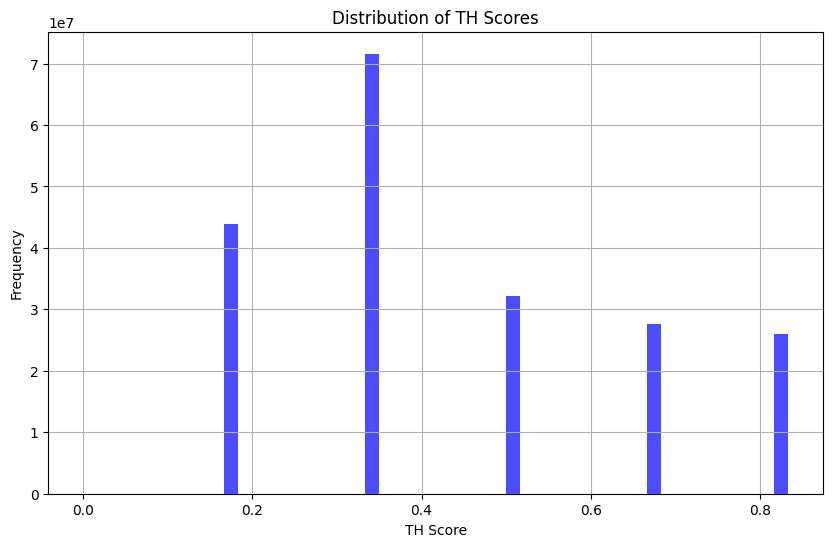

In [8]:
# Distribution graph of TH scores
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of TH Scores')
plt.xlabel('TH Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [42]:
# print rankings in descending order
sorted_indices = np.argsort(values)[::-1]
sorted_scores = scores[sorted_indices]
sorted_values = values[sorted_indices]
sorted_zero_indices = (zero_indices[0][sorted_indices], zero_indices[1][sorted_indices])
print("Ranked Consensus values:")
for idx in range(len(sorted_values[:20])):
    row = sorted_zero_indices[0][idx]
    col = sorted_zero_indices[1][idx]
    score = sorted_scores[idx]
    value = sorted_values[idx]
    gene_name = adata.var_names[col]
    cell_barcode = adata.obs_names[row]
    cell_type = adata.obs["Celltype"][row]
    
    print(f"Rank {idx+1}: Row {row}, Col {col} - Gene: {gene_name}, Cell: {cell_type} ({cell_barcode})")
    print(f"TH-Score: {score:.4f}, Consensus Value: {value:.4f}")
    for method in valid_methods:
        method_idx = valid_methods.index(method)
        imputed_value = filtered_matrices[method_idx][row, col]
        print(f"  {method}: Imputed Value: {imputed_value:.4f}")
    print()

# consensus value (weighted average of imputed values)
top_idx = np.argmax(values)
top_row = zero_indices[0][top_idx]
top_col = zero_indices[1][top_idx]

# Get gene and cell information
gene_name = adata.var_names[top_col]
cell_barcode = adata.obs_names[top_row]
cell_type = adata.obs["Celltype"][top_row]

print(f"Highest-ranked zero (with consensus values): Row {top_row}, Col {top_col}")
print(f"Gene: {gene_name}, Cell: {cell_type} ({cell_barcode})")

Ranked Consensus values:
Rank 1: Row 4256, Col 8602 - Gene: ENSG00000164816, Cell: Enterocytes CA1 CA2 CA4- (I117351_L-GCACATACAAGCCATT)
TH-Score: 0.8333, Consensus Value: 6.2869
  SAUCIE: Imputed Value: 1.6164
  MAGIC: Imputed Value: 0.0000
  deepImpute: Imputed Value: 4.4889
  scScope: Imputed Value: 21.8220
  scVI: Imputed Value: 0.0000
  knn_smoothing: Imputed Value: 9.7940

Rank 2: Row 5250, Col 8602 - Gene: ENSG00000164816, Cell: Enterocytes CA1 CA2 CA4- (N128400_L-GTTCCGTCATCCGATA)
TH-Score: 0.8333, Consensus Value: 5.5666
  SAUCIE: Imputed Value: 1.7874
  MAGIC: Imputed Value: 0.0000
  deepImpute: Imputed Value: 4.7798
  scScope: Imputed Value: 17.0245
  scVI: Imputed Value: 0.0000
  knn_smoothing: Imputed Value: 9.8080

Rank 3: Row 7169, Col 8602 - Gene: ENSG00000164816, Cell: Tuft cells (N178961_L-ATTCCCGAGCCATGCC)
TH-Score: 0.8333, Consensus Value: 5.5276
  SAUCIE: Imputed Value: 1.5079
  MAGIC: Imputed Value: 0.0000
  deepImpute: Imputed Value: 4.0700
  scScope: Imputed Val

In [39]:
# For that first position, what values do the 6 methods propose?
all_values = []
for i, method_name in enumerate(valid_methods):
    imputed = filtered_matrices[i]
    value = imputed[top_row, top_col]
    all_values.append(value)
    print(f"{method_name}: {value:.4f}")
# What’s the spread (min/max/mean)?
all_values = np.array(all_values)
print(f"Min: {np.min(all_values):.4f}, Max: {np.max(all_values):.4f}, Mean: {np.mean(all_values):.4f}")
    

SAUCIE: 1.6164
MAGIC: 0.0000
deepImpute: 4.4889
scScope: 21.8220
scVI: 0.0000
knn_smoothing: 9.7940
Min: 0.0000, Max: 21.8220, Mean: 6.2869


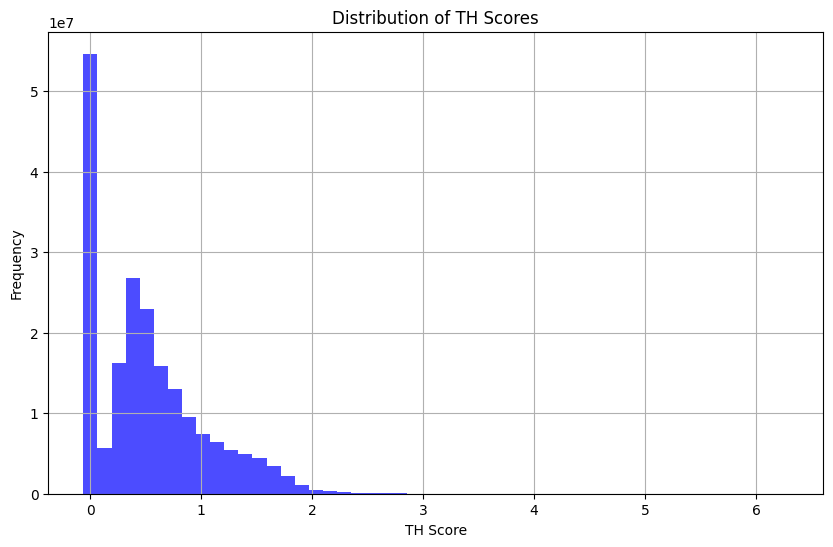

0.8333333333333333


In [44]:
# Distribution graph of TH scores
plt.figure(figsize=(10, 6))
plt.hist(values, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of TH Scores')
plt.xlabel('TH Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()
print(np.max(scores))


In [45]:
df = pd.DataFrame(scores)
stats = df.describe()
print(stats)

                  0
count  2.014540e+08
mean   4.340203e-01
std    2.190001e-01
min    0.000000e+00
25%    3.333333e-01
50%    3.333333e-01
75%    6.666667e-01
max    8.333333e-01


In [46]:
df = pd.DataFrame(values)
stats = df.describe()
print(stats)

                  0
count  2.014540e+08
mean   5.250165e-01
std    4.922224e-01
min   -6.019307e-02
25%    1.690256e-02
50%    4.358563e-01
75%    7.846782e-01
max    6.286886e+00


In [ ]:
# trustworthy score rank 1:
# so many 0.833s

# concensus value rank 1:
# Rank 1: Row 4256, Col 8602 - Gene: ENSG00000164816, Cell: Enterocytes CA1 CA2 CA4- (I117351_L-GCACATACAAGCCATT) Consensus Value: 6.2947

In [14]:
import numpy as np
import json

def log_message(msg):
    print(msg)

def inspect_gene_names(adata):
    log_message(f"Gene name format example: first 5 genes - {', '.join(adata.var_names[:5])}")
    common_markers = ['MUC2', 'LGR5', 'OLFM4', 'LYZ', 'DEFA5']
    lowercase_var_names = [name.lower() for name in adata.var_names]
    for marker in common_markers:
        lower_marker = marker.lower()
        if lower_marker in lowercase_var_names:
            idx = lowercase_var_names.index(lower_marker)
            actual_name = adata.var_names[idx]
            log_message(f"Found marker {marker} as {actual_name}")
    if hasattr(adata.var, 'columns') and len(adata.var.columns) > 0:
        log_message(f"Additional gene metadata columns: {', '.join(adata.var.columns)}")
        symbol_cols = [col for col in adata.var.columns
                      if 'symbol' in col.lower() or 'name' in col.lower() or 'gene' in col.lower()]
        if symbol_cols:
            log_message(f"Potential gene symbol columns: {', '.join(symbol_cols)}")
            log_message(f"Sample from {symbol_cols[0]}: {adata.var[symbol_cols[0]].iloc[:5].tolist()}")
    return symbol_cols if 'symbol_cols' in locals() else []


def find_gene_mapping(adata, marker_genes):
    symbol_cols = inspect_gene_names(adata)
    gene_mapping = {}
    
    all_markers = set()
    for cell_type in marker_genes:
        all_markers.update(marker_genes[cell_type])
    
    for gene in all_markers:
        if gene in adata.var_names:
            gene_mapping[gene] = gene
            continue
            
        lowercase_var_names = [name.lower() for name in adata.var_names]
        if gene.lower() in lowercase_var_names:
            idx = lowercase_var_names.index(gene.lower())
            gene_mapping[gene] = adata.var_names[idx]
            continue
            
        for col in symbol_cols:
            if gene in adata.var[col].values:
                indices = adata.var.index[adata.var[col] == gene].tolist()
                if indices:
                    gene_mapping[gene] = indices[0]
                    break
    
    return gene_mapping

def compute_descending_ranks(vec):
    """Return 1-based ranks (largest=1) for a 1-D array in O(n log n)."""
    order = np.argsort(-vec)          # indices that would sort descending
    ranks = np.empty_like(order)
    ranks[order] = np.arange(1, len(vec)+1)
    return ranks

th_ranks       = compute_descending_ranks(scores)   # shape (n_cells,)
consensus_ranks = compute_descending_ranks(values)  # shape (n_cells,)
cell_index = {k: i for i, k in enumerate(adata.obs.index)}

with open("./data/marker_genes.json") as f:
    marker_genes = json.load(f)
gene_mapping = find_gene_mapping(adata, marker_genes)


for cell_type, markers in marker_genes.items():
    if 'Celltype' not in adata.obs.columns:
        print("Column 'Celltype' not found in adata.obs")
        break

    matching = adata.obs.index[adata.obs['Celltype'] == cell_type]
    if len(matching) == 0:
        continue

    sample_idx = cell_index[matching[0]]          # integer row index
    th_rank_sample       = th_ranks[sample_idx]   # one lookup
    consensus_rank_sample = consensus_ranks[sample_idx]

    for gene in markers:
        if gene not in gene_mapping:               # skip unmapped genes
            continue
        print(
            f"Cell Type: {cell_type:15} "
            f"Gene: {gene:7} "
            f"TH Rank: {th_rank_sample}/{len(scores)} {th_rank_sample/len(scores)*100:.2f}%, "
            f"Consensus Rank: {consensus_rank_sample}/{len(values)} {consensus_rank_sample/len(values)*100:.2f}%"
        )


Gene name format example: first 5 genes - ENSG00000228463, ENSG00000237094, ENSG00000228327, ENSG00000237491, ENSG00000177757
Additional gene metadata columns: feature_is_filtered, feature_name, feature_reference, feature_biotype, feature_length, feature_type
Potential gene symbol columns: feature_name
Sample from feature_name: ['ENSG00000228463.10', 'ENSG00000237094.13', 'ENSG00000228327.6', 'LINC01409', 'FAM87B']
Cell Type: Enterocytes BEST4 Gene: BEST4   TH Rank: 85903281/201453960 42.64%, Consensus Rank: 152958850/201453960 75.93%
Cell Type: Enterocytes BEST4 Gene: OTOP2   TH Rank: 85903281/201453960 42.64%, Consensus Rank: 152958850/201453960 75.93%
Cell Type: Enterocytes BEST4 Gene: CA7     TH Rank: 85903281/201453960 42.64%, Consensus Rank: 152958850/201453960 75.93%
Cell Type: Enterocytes BEST4 Gene: GUCA2A  TH Rank: 85903281/201453960 42.64%, Consensus Rank: 152958850/201453960 75.93%
Cell Type: Enterocytes BEST4 Gene: GUCA2B  TH Rank: 85903281/201453960 42.64%, Consensus Rank